# Project 2: Recommenders using Collaborative Filtering - Movielens 100k

## carlos.e.hernandez@oracle.com
### Slack: carlosh

# Introduction

In this project, you will practice Collaborative Filtering which was introduced in Unit 13 of the Basic training. You will feed users' ratings of movies to a Collaborative Filter model. This will allow you to predict how users would rate other movies.

Then pick one user and:
1. See how they rated movies (what movies they like) and get predictions of movies they havn't seen
1. Which ones they would or wouldn't like?
1. Do you think that predictions make sense? Tell a story about it.

We recommend using Python's surprise library for this project (and lightfm for production scenarios).

The data we will use for this project can be found here:
https://grouplens.org/datasets/movielens/ (small 100k version), more specifically, it can be downloaded from http://files.grouplens.org/datasets/movielens/ml-100k.zip

# Environment variables

Make sure to configure these variables to the apropriate locations and to set them prior to executing any import Python statement.

While SURPRISE_DATA_FOLDER is optional and will default to `~/.surprise_data/`, DATA_LOCATION is not and should be set to a valid folder in the local filesystem.

In [1]:
# Optional, SURPRISE_DATA_FOLDER is a special env variable used by the Surprise
# library, set this to a specific folder to where you want to cache the files
#  for the built-in datasets loaded by Surprise, otherwise, comment it our and 
#  by default datasets will be stored in '~/.surprise_data'

%env SURPRISE_DATA_FOLDER=/content/drive/MyDrive/Datasets/Surpriselib-datasets
#%env SURPRISE_DATA_FOLDER=/workspace/datasets/surpriselib-datasets
!echo $SURPRISE_DATA_FOLDER

# We need to download some other files for additional info on the data, this
#  will not be used for training but it will be used to interpret results by 
#  pulling info on the movies and users.

# Set this variable to wherever you want to download these additional files
%env DATA_LOCATION=/content/drive/MyDrive/Colab Notebooks/Oracle/Assignment2/
#%env DATA_LOCATION=/workspace/datasets/Oracle/Assignment2/
!echo $DATA_LOCATION

env: SURPRISE_DATA_FOLDER=/content/drive/MyDrive/Datasets/Surpriselib-datasets
/content/drive/MyDrive/Datasets/Surpriselib-datasets
env: DATA_LOCATION=/content/drive/MyDrive/Colab Notebooks/Oracle/Assignment2/
/content/drive/MyDrive/Colab Notebooks/Oracle/Assignment2/


# Dependency installation

In [3]:
!pip install surprise numpy matplotlib pandas ipython

# Imports and tools

In [4]:
%matplotlib inline

import os
import random

from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise import SVD, SVDpp, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import Dataset, dump, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split
from surprise.model_selection import GridSearchCV

# Connect to Google Drive if hosting the files there
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
def print_marquee(msg: str):
    """
    Prints a centered message with a marquee of * 
    """
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

def param_searcher_reporter(param_searcher: GridSearchCV):

    print_marquee("Hyperparam Search Results")

    print("\nThe best hyperparameters for each of the metrics were:")
    
    for metric, score in param_searcher.best_score.items():
        print(f"{metric} with a score of {score}:")
        print(param_searcher.best_params.get(metric))
        print("\n")

    print_marquee("Detailed search report")
    result_report = pd.DataFrame.from_dict(param_searcher.cv_results)
    display(result_report)

def plot_histogram(df: pd.DataFrame, nrows: int, ncols: int):
    """
    Plots a series of histograms for a dataframe in a nrows x ncols distribution
    """
    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(14,14))
    
    for n, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, n+1)
        df[col].plot.hist(ax = plt.gca(),
                          bins=20,
                          legend=True)
        

def plot_value_count_histogram(df: pd.DataFrame, cols_to_plot: list = None):
    
    cols_to_plot = df.columns if not cols_to_plot else cols_to_plot

    fig_count = plt.figure()

    for idx, cat_col in enumerate(cols_to_plot):
        ax = fig_count.add_subplot(3, 2, idx + 1)

        df[cat_col].value_counts().plot(kind='bar',
                                        ax=ax,
                                        figsize=(14,14),
                                        legend=True)

    plt.show()

# Data

The full data set, is composed of 100000 ratings by 943 users on 1682 items.
Each user has rated at least 20 movies. Users and items are numbered consecutively from 1. The data is randomly ordered. The file file in the ZIP container that we'll use for this project is `u.data`.

The columns in the original data are:

1. user_id (int). Numbered consecutively from 1.
1. item_id (int). Numbered consecutively from 1.
1. rating (int). A discrete value from 1-5 with 5 being the highest rating.
1. timestamp (int). The time stamps are unix seconds since 1/1/1970 UTC

Additionally, we can replace the timestamp column with a parsed version (datetime) column to show what that timestamp represents as a real date, but we will not need it for our recommendations using Surprise, as a matter of fact, Surprise has a hard requirement that data must only have:

1. User_ID
1. Item_ID
1. Rating

And it needs to be stored in a specially crafted Surprise dataframe.

We could do some exploratory data on the characteristics of each user, which are stored in a separate file (*u.user*) but we will not be able to add this information to our Surprise dataframe.

In [6]:
# We'll use surprise's mechanism to fetch the dataset, if prompted, input Y
#  to download the dataset. The dataset will be pulled from 
#  http://files.grouplens.org/datasets/movielens/ml-100k.zip
data = Dataset.load_builtin('ml-100k')

# We'll temporarily transform the Surprise Dataframe to a Pandas Dataframe to
#  be able to inspect the data, however, in order to use the Surprise lib, we'll
#  need to use a Surprise dataframe
data_pd = pd.DataFrame(data.raw_ratings, columns=["user_id",
                                                  "item_id",
                                                  "rating",
                                                  "timestamp"],
                       dtype=np.int8)

data_pd["timestamp"] = pd.to_datetime(data_pd['timestamp'],
                                      unit='s')


display(data_pd.head())

print(f"Data shape: {data_pd.shape}")

,user_id,item_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


Data shape: (100000, 4)


In [ ]:
# Get the movies and users datasets
!wget -P "$DATA_LOCATION" http://files.grouplens.org/datasets/movielens/ml-100k/u.item
!wget -P "$DATA_LOCATION" http://files.grouplens.org/datasets/movielens/ml-100k/u.user

--2021-01-09 17:27:41--  http://files.grouplens.org/datasets/movielens/ml-100k/u.item
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236344 (231K)
Saving to: ‘/workspace/datasets/Oracle/Assignment2/u.item’

u.item              100%[===================>] 230.80K   584KB/s    in 0.4s    

2021-01-09 17:27:42 (584 KB/s) - ‘/workspace/datasets/Oracle/Assignment2/u.item’ saved [236344/236344]

--2021-01-09 17:27:42--  http://files.grouplens.org/datasets/movielens/ml-100k/u.user
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22628 (22K)
Saving to: ‘/workspace/datasets/Oracle/Assignment2/u.user’

u.user              100%[===================>]  22.10K  --.-KB/s    i

In [8]:
data_root_location = os.environ['DATA_LOCATION']

# Additional information on movies and users used not for training but for
#  interpretation purposes
data_users = pd.read_csv(f"{data_root_location}u.user",
                         names=[
                                 "user_id",
                                 "age",
                                 "gender",
                                 "occupation",
                                 "zip_code"
                         ],
                         sep="|",
                         dtype={
                                "user_id": "str",
                                "age": "int",
                                "gender": "category",
                                "occupation": "category",
                                "zip_code": "category"
                        })


data_movies = pd.read_csv(f"{data_root_location}u.item",
                         names=[
                                 "movie_id",
                                 "movie_title",
                                 "release_date",
                                 "video_release_date",
                                 "imdb_url",
                                 "unknown",
                                 "action",
                                 "adventure",
                                 "animation",
                                 "children",
                                 "comedy",
                                 "crime",
                                 "documentary",
                                 "drama",
                                 "fantasy",
                                 "film_noir",
                                 "horror",
                                 "musical",
                                 "mystery",
                                 "romance",
                                 "scifi",
                                 "thriller",
                                 "war",
                                 "western"
                         ],
                         sep="|",
                         dtype={
                                "movie_id": "str",
                                "movie_title": "str",
                                "imdb_url": "str",
                                "unknown": "int",
                                "action": "int",
                                "adventure": "int",
                                "animation": "int",
                                "children": "int",
                                "comedy": "int",
                                "crime": "int",
                                "documentary": "int",
                                "drama": "int",
                                "fantasy": "int",
                                "film_noir": "int",
                                "horror": "int",
                                "musical": "int",
                                "mystery": "int",
                                "romance": "int",
                                "scifi": "int",
                                "thriller": "int",
                                "war": "int",
                                "western": "int"
                        },
                       parse_dates=["release_date", "video_release_date"],
                       encoding="CP1252")

display(data_users.head(3))
display(data_movies.head(3))

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067


,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,Toy Story (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## EDA


In [9]:
print(f"Unique users: {len(data_pd['user_id'].unique())}")
print(f"Unique movies: {len(data_pd['item_id'].unique())}")

print("\n\nDatatypes:")
display(data_pd.info())


print("\n\nData Description:")
display(data_pd.describe(include="all", datetime_is_numeric=True))

Unique users: 943
Unique movies: 1682


Datatypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    100000 non-null  object        
 1   item_id    100000 non-null  object        
 2   rating     100000 non-null  int8          
 3   timestamp  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int8(1), object(2)
memory usage: 2.4+ MB


None



Data Description:


,user_id,item_id,rating,timestamp
count,100000,100000,100000.000000,100000
unique,943,1682,NaN,NaN
top,405,50,NaN,NaN
freq,737,583,NaN,NaN
mean,NaN,NaN,3.529860,1997-12-31 00:40:51.488619392
min,NaN,NaN,1.000000,1997-09-20 03:05:10
25%,NaN,NaN,3.000000,1997-11-13 19:18:29.500000
50%,NaN,NaN,4.000000,1997-12-22 21:42:24
75%,NaN,NaN,4.000000,1998-02-23 18:53:04
max,NaN,NaN,5.000000,1998-04-22 23:10:38


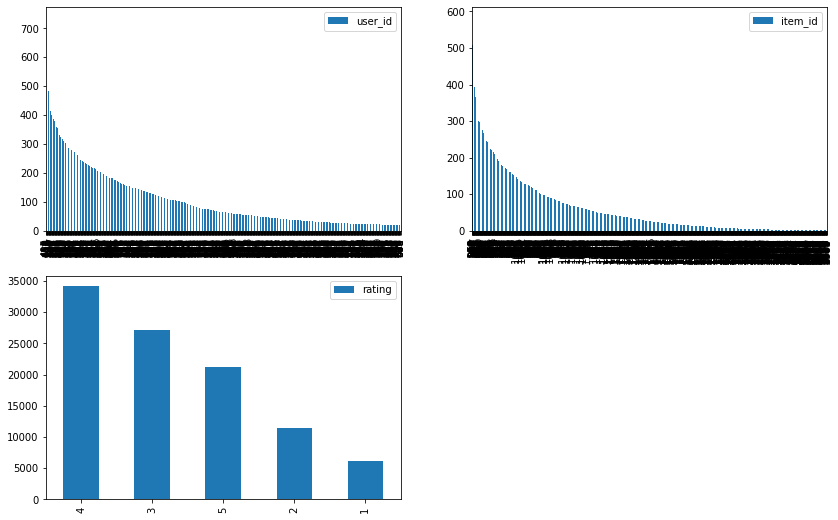

In [ ]:
plot_value_count_histogram(data_pd, ["user_id", "item_id", "rating"])

In [10]:
most_rw_movie = data_movies[data_movies["movie_id"] == data_pd["item_id"].mode()[0]]["movie_title"].values[0]
print(f"Most reviewed movie is: {most_rw_movie}")

Most reviewed movie is: Star Wars (1977)


### Movie count by genre

In [51]:
# Remove the columns not related to genre
non_genre_columns = ["movie_id", "movie_title","release_date",
                     "video_release_date","imdb_url"]

data_genre_info = data_movies.drop(non_genre_columns, axis=1)

# Sum the one-hot encoded columns for each genre
display(data_genre_info.sum(axis=0).to_frame(name="count"))

,count
unknown,2
action,251
adventure,135
animation,42
children,122
comedy,505
crime,109
documentary,50
drama,725
fantasy,22


### Best rated movies

Let's get the best rated movies. To do this, let's take into account how many reviews a movie has, otherwise we could get movies that were best reviewed by just a handful of people. Let's get the best rated movies that have at least 25 reviews.

This will also allow us to experiment with the flattening of the multiple dataframes.

In [52]:
# Get the review counts for each movie
review_cnt = data_pd.groupby(["item_id"]).size().reset_index(name='review_counts')

# Get the average rating for each movie
best_reviewed_movies = data_pd.groupby(["item_id"]).aggregate(np.mean)

# Merge the counts and the average reviews
best_reviewed_movies = best_reviewed_movies.merge(review_cnt, left_on="item_id",
                                                  right_on="item_id")

# Get the names of the movies from the movie dataframe
best_reviewed_movies = (best_reviewed_movies.merge(
    data_movies[["movie_id", "movie_title"]], left_on='item_id', right_on='movie_id')).drop("item_id", axis=1)

# Sort by review_counts and ratings
best_reviewed_movies = best_reviewed_movies.sort_values(
    by=["rating"], ascending=False)

print("Top 25 Rated movies:")
best_reviewed_movies.head(25)

Top 25 Rated movies:


,rating,review_counts,movie_id,movie_title
558,5.000000,2,1500,Santa with Muscles (1996)
327,5.000000,3,1293,Star Kid (1997)
211,5.000000,3,1189,Prefontaine (1997)
727,5.000000,1,1653,Entertaining Angels: The Dorothy Day Story (1996)
520,5.000000,2,1467,"Saint of Fort Washington, The (1993)"
138,5.000000,1,1122,They Made Me a Criminal (1939)
666,5.000000,1,1599,Someone Else's America (1995)
226,5.000000,1,1201,Marlene Dietrich: Shadow and Light (1996)
597,5.000000,1,1536,Aiqing wansui (1994)
1477,5.000000,1,814,"Great Day in Harlem, A (1994)"


This looks fine, at least at first glance. We can get the mean rating for all and each movie, but we also see that the top rated movies are so by virtue of having a really low amount of reviews. In more than one case, we have a single person rating an unknown movie with the highest rating (maybe the director of said movie?).

Let's see the distribution of review counts for the all of the movies.

In [17]:
best_reviewed_movies[["review_counts"]].describe()

,review_counts
count,1682.000000
mean,59.453032
std,80.383846
min,1.000000
25%,6.000000
50%,27.000000
75%,80.000000
max,583.000000


We see here that the mean review count is about 59 reviews, that for the 3rd
quartile it there are 80 reviews and that the standard deviation is about 80.

Let's define a rule where, a movie most have at least $N$ ratings before we can assume that the rating is valuable.

Let's try this with $N=25$ as a threshold, just so that we don't lose a lot of the data while also having more reasonable and sound reviews.

In [54]:
# Sort by review_counts and ratings
best_reviewed_movies = best_reviewed_movies[best_reviewed_movies["review_counts"] >= 25 ].sort_values(
    by=["rating"], ascending=False)

print("Top 25 Rated movies:")
best_reviewed_movies.head(25)

Top 25 Rated movies:


,rating,review_counts,movie_id,movie_title
1026,4.491071,112,408,"Close Shave, A (1995)"
926,4.466443,298,318,Schindler's List (1993)
760,4.466102,118,169,"Wrong Trousers, The (1993)"
1109,4.456790,243,483,Casablanca (1942)
157,4.447761,67,114,Wallace & Gromit: The Best of Aardman Animatio...
1283,4.445230,283,64,"Shawshank Redemption, The (1994)"
1243,4.387560,209,603,Rear Window (1954)
223,4.385768,267,12,"Usual Suspects, The (1995)"
1128,4.358491,583,50,Star Wars (1977)
770,4.344000,125,178,12 Angry Men (1957)


This new data makes more sense. The movies in the top 25 are popular movies with a large ammount of reviews that better support their high rating.

We'll use this filtered data for the training of the final model.

In [55]:
data_pd_filtered = data_pd[data_pd["item_id"].isin(best_reviewed_movies["movie_id"])]
print(f"Valid reviews: {data_pd_filtered.shape[0]}")

# Convert this data to a Surprise-usable dataframe
# The columns must correspond to user id, item id and ratings (in that order).
data_filtered = Dataset.load_from_df(data_pd_filtered[['user_id', 'item_id', 'rating']],
                                     Reader(rating_scale=(1, 5)))

Valid reviews: 93496


### Insights

We can confirm by the shape of the data and the description of the data that we have 100k records for 1682 unique movies and 943 unique users.

The count of movies per genre is as follows:

|Genre|Count|
|:---|---:|
unknown    |      2
action     |    251
adventure  |    135
animation  |     42
children   |    122
comedy     |    505
crime      |    109
documentary|     50
drama      |    725
fantasy    |     22
film_noir  |     24
horror     |     92
musical    |     56
mystery    |     61
romance    |    247
scifi      |    101
thriller   |    251
war        |     71
western    |     27

Which shows that most of the movies are drams, comedies, action, romance and thriller movies.

We can also see that the average of the ratings is about 3.53, the most prolific rater was user 405 with 737 reviews and that the most reviewed movie is movie 50 (Star Wars 1977) with 563 reviews. People usually voted 4 or 3 and seldom gave the worst rating.

Finally, all of the ratings were made between September 20th 1997-April 4th 1998.

There are no missing values in this data, all columns for all 100k records have some data but after removing those movies that have less than 25 ratings, we have about 93496 valid records.





# Models

We'll use the data as imported by Surprise, as it is already in the mandatory shape expected by the library and feed it to the training of the following models:

1. knns.KNNBasic	A basic collaborative filtering algorithm.
1. knns.KNNWithMeans	A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
1. knns.KNNWithZScore	A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.
1. knns.KNNBaseline	A basic collaborative filtering algorithm taking into account a baseline rating.
1. matrix_factorization.SVD	The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.
1. matrix_factorization.SVDpp	The SVD++ algorithm, an extension of SVD taking into account implicit ratings.

We'll use 5-fold cross-validation to get a report on the following metrics:

1. rmse	Root Mean Squared Error.
1. mse	Mean Squared Error.
1. mae	Mean Absolute Error.

We'll first do 5-fold CV to find which models perform better without any hypeparameter tuning.

From that, we'll choose the best model and retrain it with and perform a Grid Search to fine-tune the hyperparameters.

After that, we'll get a sample of users who haven't rated some movies and perform predictions on them to see what movies they would like that they haven't seen.

## KNNBasic

In [ ]:
knn_basic = KNNBasic()

# Run 5-fold cross-validation and print results
cross_validate(knn_basic,
               data,
               measures=['RMSE', 'MSE','MAE'],
               cv=5,
               verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9761  0.9750  0.9827  0.9795  0.9801  0.9787  0.0028  
MSE (testset)     0.9527  0.9507  0.9656  0.9595  0.9606  0.9578  0.0054  
MAE (testset)     0.7707  0.7710  0.7766  0.7740  0.7730  0.7731  0.0022  
Fit time          0.62    0.49    0.57    0.44    0.58    0.54    0.06    
Test time         4.39    3.84    3.91    3.51    3.94    3.92    0.28    


{'fit_time': (0.6161997318267822,
  0.49053955078125,
  0.5689845085144043,
  0.4423847198486328,
  0.5797796249389648),
 'test_mae': array([0.77065664, 0.77104666, 0.77658647, 0.77400179, 0.77297974]),
 'test_mse': array([0.95274995, 0.95067954, 0.96563437, 0.95951573, 0.96060941]),
 'test_rmse': array([0.97608911, 0.97502797, 0.98266697, 0.97954874, 0.98010683]),
 'test_time': (4.394472360610962,
  3.8367810249328613,
  3.906278610229492,
  3.5078704357147217,
  3.935349464416504)}

## KNN With Means

In [ ]:
knn_means = KNNWithMeans()

# Run 5-fold cross-validation and print results
cross_validate(knn_means,
               data,
               measures=['RMSE', 'MSE','MAE'],
               cv=5,
               verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9585  0.9452  0.9512  0.9531  0.9448  0.9505  0.0051  
MSE (testset)     0.9187  0.8934  0.9048  0.9083  0.8927  0.9036  0.0097  
MAE (testset)     0.7562  0.7457  0.7491  0.7486  0.7443  0.7488  0.0041  
Fit time          0.53    0.45    0.40    0.41    0.70    0.50    0.11    
Test time         4.30    3.58    3.94    3.93    4.48    4.05    0.32    


{'fit_time': (0.5335729122161865,
  0.44831204414367676,
  0.403350830078125,
  0.41486024856567383,
  0.7044448852539062),
 'test_mae': array([0.75621959, 0.74571951, 0.74909609, 0.74862997, 0.74433074]),
 'test_mse': array([0.91867945, 0.89343585, 0.90476603, 0.90831648, 0.89265222]),
 'test_rmse': array([0.95847767, 0.94521736, 0.9511919 , 0.95305639, 0.94480274]),
 'test_time': (4.299438714981079,
  3.5783355236053467,
  3.9356260299682617,
  3.9322197437286377,
  4.484969615936279)}

## KNN With Z-Score

In [ ]:
knn_zscore = KNNWithZScore()

# Run 5-fold cross-validation and print results
cross_validate(knn_zscore,
               data,
               measures=['RMSE', 'MSE','MAE'],
               cv=5,
               verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9472  0.9477  0.9445  0.9569  0.9580  0.9509  0.0055  
MSE (testset)     0.8972  0.8982  0.8921  0.9156  0.9177  0.9042  0.0104  
MAE (testset)     0.7438  0.7454  0.7411  0.7489  0.7489  0.7456  0.0030  
Fit time          0.55    0.59    0.61    0.67    0.69    0.62    0.05    
Test time         4.75    4.34    4.79    4.56    4.21    4.53    0.23    


{'fit_time': (0.5487475395202637,
  0.5870163440704346,
  0.6104798316955566,
  0.6698813438415527,
  0.6906378269195557),
 'test_mae': array([0.74375969, 0.74543847, 0.74112314, 0.74893544, 0.74889072]),
 'test_mse': array([0.89718697, 0.89820911, 0.89209788, 0.91557154, 0.91771477]),
 'test_rmse': array([0.94719954, 0.94773895, 0.94450933, 0.95685502, 0.95797431]),
 'test_time': (4.748639106750488,
  4.335026502609253,
  4.787675142288208,
  4.5577309131622314,
  4.209852933883667)}

## KNN With Baseline

In [ ]:
knn_baseline = KNNBaseline()

# Run 5-fold cross-validation and print results
cross_validate(knn_baseline,
               data,
               measures=['RMSE', 'MSE','MAE'],
               cv=5,
               verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9320  0.9274  0.9270  0.9333  0.9300  0.9300  0.0025  
MSE (testset)     0.8687  0.8600  0.8593  0.8711  0.8649  0.8648  0.0046  
MAE (testset)     0.7320  0.7318  0.7295  0.7351  0.7347  0.7326  0.0021  
Fit time          0.62    0.66    0.64    0.78    0.71    0.68    0.06    
Test time         4.38    4.52    4.41

{'fit_time': (0.6234405040740967,
  0.6600501537322998,
  0.644733190536499,
  0.7815835475921631,
  0.7102808952331543),
 'test_mae': array([0.73201253, 0.73175077, 0.72953203, 0.73509043, 0.73472701]),
 'test_mse': array([0.86867644, 0.86004187, 0.85933562, 0.87112483, 0.86491255]),
 'test_rmse': array([0.93202813, 0.92738442, 0.92700357, 0.93334068, 0.93000675]),
 'test_time': (4.375678062438965,
  4.515260219573975,
  4.407959461212158,
  4.611237049102783,
  4.540057420730591)}

## Singular Value Decomposition SVD

In [ ]:
svd = SVD()

# Run 5-fold cross-validation and print results
cross_validate(svd,
               data,
               measures=['RMSE', 'MSE','MAE'],
               cv=5,
               verbose=True)

Evaluating RMSE, MSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9304  0.9445  0.9395  0.9266  0.9367  0.9355  0.0064  
MSE (testset)     0.8657  0.8920  0.8827  0.8587  0.8774  0.8753  0.0119  
MAE (testset)     0.7345  0.7437  0.7389  0.7317  0.7366  0.7371  0.0041  
Fit time          5.43    5.30    5.12    5.17    4.80    5.16    0.21    
Test time         0.34    0.16    0.16    0.28    0.15    0.22    0.08    


{'fit_time': (5.426677465438843,
  5.303649425506592,
  5.1150994300842285,
  5.169849395751953,
  4.798031330108643),
 'test_mae': array([0.73452842, 0.74374695, 0.73890959, 0.73172016, 0.73661867]),
 'test_mse': array([0.86569895, 0.89202291, 0.88265587, 0.85865016, 0.8774413 ]),
 'test_rmse': array([0.93042945, 0.94446965, 0.93949767, 0.92663378, 0.93671837]),
 'test_time': (0.34159016609191895,
  0.16489672660827637,
  0.15627408027648926,
  0.2834608554840088,
  0.15371179580688477)}

## SVD++

In [ ]:
svdpp = SVDpp()

# Run 5-fold cross-validation and print results
cross_validate(svdpp,
               data,
               measures=['RMSE', 'MSE','MAE'],
               cv=5,
               verbose=True)

Evaluating RMSE, MSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9144  0.9156  0.9236  0.9284  0.9158  0.9196  0.0055  
MSE (testset)     0.8361  0.8383  0.8530  0.8619  0.8387  0.8456  0.0101  
MAE (testset)     0.7184  0.7193  0.7229  0.7285  0.7166  0.7211  0.0042  
Fit time          165.03  163.34  163.32  162.59  160.70  162.99  1.40    
Test time         4.40    4.35    4.66    3.86    4.09    4.27    0.27    


{'fit_time': (165.0307972431183,
  163.34148573875427,
  163.31635403633118,
  162.58744645118713,
  160.69884753227234),
 'test_mae': array([0.71839118, 0.71932495, 0.72285783, 0.72852355, 0.71664559]),
 'test_mse': array([0.83611809, 0.83828371, 0.85302588, 0.86192947, 0.8387122 ]),
 'test_rmse': array([0.91439493, 0.91557835, 0.923594  , 0.92840157, 0.91581232]),
 'test_time': (4.399968862533569,
  4.3489837646484375,
  4.662224769592285,
  3.864748239517212,
  4.086822748184204)}

## Model evaluation insight

The first results for each of the metrics show the following metrics:

&nbsp;|KNNBasic|KNNMeans|KNN-Z|KNN Baseline|SVD|SVD++
:---|---:|---:|---:|---:|---:|---:|
RMSE|0.9787|0.9595|0.9509|0.9300|0.9355|0.9196|
MSE|0.9578|0.9036|0.9042|0.8648|0.8753|0.8456|
MAE|0.7731|0.7488|0.7456|0.7326|0.7371|0.7211|

We can see that the model that had the best performance on a "default" hyperparameter configuration was SVD++, however, it also had the largest training times let's fine-tune the hyperparameters by doing a GridSearchCV.

# Best Model Hyperparameter Tuning

We'll use 5-fold Cross-Validation and use RMSE to make a determination on the
improvement of the model. We'll also ask to report the MAE just for comparison
purposes.

In [ ]:
param_grid = {
    'n_epochs': [20, 100, 150, 200], # Default is 20
    'lr_all': [0.005, 0.008, 0.012, 0.003],   # Default is 0.005
    'reg_all': [0.02, 0.09, 0.12, 0.20],       # Default is 0.02
    "random_state": [42]
    }

grid_search_svdpp = GridSearchCV(SVDpp,
                                 param_grid,
                                 measures=['RMSE','MAE'],
                                 cv=5,
                                 n_jobs=-1,
                                 joblib_verbose=2)

grid_search_svdpp.fit(data)

param_searcher_reporter(grid_search_svdpp)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.9min




*****************************
* Hyperparam Search Results *
*****************************

The best hyperparameters for each of the metrics were:
rmse with a score of 0.9102743962980119:
{'n_epochs': 200, 'lr_all': 0.003, 'reg_all': 0.12, 'random_state': 42}


mae with a score of 0.7181250110017044:
{'n_epochs': 150, 'lr_all': 0.003, 'reg_all': 0.09, 'random_state': 42}




**************************
* Detailed search report *
**************************


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 149.0min finished


,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all,param_random_state
0,0.913802,0.926159,0.913391,0.923479,0.917656,0.918897,0.005129,20,0.719321,0.728155,...,16,294.199403,17.435525,6.689980,0.509110,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.02,42
1,0.932359,0.943226,0.931051,0.940243,0.938037,0.936983,0.004632,43,0.737760,0.747905,...,44,313.405394,12.274875,6.856785,0.224909,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.09,42
2,0.937323,0.947419,0.935010,0.944090,0.942229,0.941214,0.004504,45,0.742596,0.752617,...,45,305.232550,14.958589,6.870268,0.222263,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.12,42
3,0.943396,0.952961,0.939968,0.948679,0.947628,0.946526,0.004473,50,0.749505,0.759779,...,52,324.319171,15.721796,6.665799,0.076447,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0...",20,0.005,0.20,42
4,0.918238,0.933090,0.920226,0.929474,0.922229,0.924651,0.005675,29,0.720684,0.730149,...,21,320.052510,16.170911,6.720846,0.173726,"{'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0...",20,0.008,0.02,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.923470,0.934388,0.920830,0.928679,0.927327,0.926939,0.004648,31,0.732987,0.744582,...,34,3646.379072,17.498040,3.266242,0.119962,"{'n_epochs': 200, 'lr_all': 0.012, 'reg_all': ...",200,0.012,0.20,42
60,0.998683,1.020951,1.009658,1.011397,1.003209,1.008780,0.007599,56,0.772975,0.786338,...,56,3623.922416,8.728112,3.176838,0.105094,"{'n_epochs': 200, 'lr_all': 0.003, 'reg_all': ...",200,0.003,0.02,42
61,0.908983,0.924961,0.909162,0.917272,0.914478,0.914971,0.005915,13,0.714759,0.727865,...,6,3618.623311,16.390854,2.974730,0.137972,"{'n_epochs': 200, 'lr_all': 0.003, 'reg_all': ...",200,0.003,0.09,42
62,0.905099,0.919478,0.904429,0.912522,0.909845,0.910274,0.005494,1,0.714111,0.726899,...,4,3607.221354,13.498705,2.788327,0.282528,"{'n_epochs': 200, 'lr_all': 0.003, 'reg_all': ...",200,0.003,0.12,42


## Hyperparameter tuning insight

We can see that the Grid Search for better hyperparams yielded better results, we managed to get

**rmse** with a score of 0.9102743962980119 which is a small improvement over the 0.9196 with default hyperparams. In particular we needed to set:

1. 'n_epochs': 200
1. 'lr_all': 0.003
1. 'reg_all': 0.12

## Best Model Training

Let's train a model with the best hyperparams found and save the model so that
we can continue working on it without having to train it again.

We'll use the data where we filtered out the movies with little ratings.

### **WARNING: Only run the following cell if you want to run the training from scratch, if you already have a trained model, use the cell aftwerwards to load the model from disk and continue.**

In [ ]:
best_model = SVDpp(n_epochs=200,
                   lr_all=0.003,
                   reg_all=0.12,
                   random_state=42)

trainset = data_filtered.build_full_trainset()

print("Training the model...")
best_model.fit(trainset)

print("Training Done! Saving model to storage...")

# Save the model to disk, the model takes about 44 minutes to train
dump.dump(f"{data_root_location}surprise_best_model_svdpp.bin", algo=best_model)


Training the model...
Training Done! Saving model to storage...


In [ ]:
# If the model was previously trained and available in the file system, you
#  can uncomment the following line to load it and avoid training it again

#_, best_model = dump.load(f"{data_root_location}surprise_best_model_svdpp.bin")


# Test set predictions - Suggesting new movies to watch!

For this part, we'll first create an anti-test-set from the data. An
anti-test-set is defined by the Surprise library as:

> The ratings are all the ratings that are not in the trainset, i.e. all the ratings $r_{ui}$ where the user $u$ is known, the item $i$ is known, but the rating $r_{ui}$ is not in the trainset. As $r_{ui}$ is unknown, it is either replaced by the fill value or assumed to be equal to the mean of all ratings global_mean.

An anti-set contains all tuples of `(user_id, movie_id, default_rating)` for all those movies that don't have a rating yet, in other words, those movies that the users are yet to see.

This anti-set is not sorted in any way, so let's first put those tuples in a
dictionary where the key will be the user ID, that way we will be able to fetch
all movies that are yet to be seen by some user quickly and, more importantly,
allow us to compare that with the movies that the user has already seen to
verify if the predictions make sense.

The anti-set may be configured to have a rating by default. If not configured,
the rating will be set to the global mean of ratings. We'll configure this filling parameter to be 0 instead.

After that, we'll pick the users with the most and less pending ratings and choose 8 more users at random to perform predictions on their missing movies.

We'll then recommend the top 10 movies for each user and check the bottom 10 just for verification purposes.

In [ ]:
# Get a test set of (user, item, rating) where user and item are known but
#  rating is missing in the data set, i.e. get all items that haven't been
#  rated by users

trainset = data_filtered.build_full_trainset()

testset = trainset.build_anti_testset(fill=0)

print(f"Pending ratings: {len(testset)}")

print(f"Movies in trainset: {trainset.n_items}")
print(f"Users in trainset: {trainset.n_users}")
print(f"Ratings in trainset: {trainset.n_ratings}")



Pending ratings: 728800
Movies in trainset: 872
Users in trainset: 943
Ratings in trainset: 93496


In [ ]:
# Index movies-to-be-rated in a dictionary where the key is the user ID and
#  the value is the tuple in the format the model expects for predictions.
movies_2b_rated_by_user = {}

for user_id, movie_id, rating in testset:
    
    if not user_id in movies_2b_rated_by_user:
        movies_2b_rated_by_user[user_id] = []
    
    movies_2b_rated_by_user[user_id].append((user_id, movie_id, rating))

In [ ]:
# Let's get some statistical info on this map

most_movies_to_be_seen = -1
least_movies_to_be_seen = 1682  # We know this is the number of unique movies

user_with_most_movies_to_be_seen = -1
user_with_least_movies_to_be_seen = -1

for user_id, movie_list in movies_2b_rated_by_user.items():

    pending_ratings = len(movie_list)
    
    if pending_ratings > most_movies_to_be_seen:
        most_movies_to_be_seen = pending_ratings
        user_with_most_movies_to_be_seen = user_id
    
    if pending_ratings < least_movies_to_be_seen:
        least_movies_to_be_seen = pending_ratings
        user_with_least_movies_to_be_seen = user_id

print(f"{len(movies_2b_rated_by_user.keys())} users have movies to be rated.")

print(f"User {user_with_most_movies_to_be_seen} hasn't seen the largest amount of movies: {most_movies_to_be_seen}")
print(f"User {user_with_least_movies_to_be_seen} has the least amount of pending ratings: {least_movies_to_be_seen}")



943 users have movies to be rated.
User 242 hasn't seen the largest amount of movies: 855
User 13 has the least amount of pending ratings: 351


We can see here that no user has rated all of the 872 unique movies in the training set. User 242 hasn't seen 655 movies, which means they have only watched 17 movies; while user 13 has seen the most movies, having 945 pending ratings which is equivalent to 521 movies already watched!

Let's choose 8 users at random and add users 242 and 13 as these would be interesting to analyze.

In [ ]:
# Let's use a seed to always get the same results
random.seed(42)
random_users = random.sample(list(movies_2b_rated_by_user.keys()), 8)

# Add our interesting users
random_users.extend(["242", "13"])
print(f"Chosen User IDs: \n{random_users}")

Chosen User IDs: 
['660', '1', '63', '764', '31', '149', '248', '297', '242', '13']


We are ready to start predicting ratings for each of the users, let's store this in a new dictionary for quick access.

In [ ]:
predictions = {}

impossible_predictions = 0

for chosen_user in random_users:
    
    # Initialize the prediction record for this user
    predictions[chosen_user] = []

    print(f"\nPredicting for user {chosen_user}...")

    for _, movie_id, _ in movies_2b_rated_by_user[chosen_user]:
        prediction = best_model.predict(chosen_user, movie_id)

        impossible_predictions += 1 if prediction.details["was_impossible"] else 0

        predictions[chosen_user].append(prediction)
    
    # After we are done, sort the predictions in reverse order on the estimated
    #  rating
    predictions[chosen_user].sort(key=lambda p: p.est, reverse=True)
    
    print(f"Done predicting for user {chosen_user}!")

print(f"\nNumber of impossible predictions: {impossible_predictions}")



Predicting for user 660...
Done predicting for user 660!

Predicting for user 1...
Done predicting for user 1!

Predicting for user 63...
Done predicting for user 63!

Predicting for user 764...
Done predicting for user 764!

Predicting for user 31...
Done predicting for user 31!

Predicting for user 149...
Done predicting for user 149!

Predicting for user 248...
Done predicting for user 248!

Predicting for user 297...
Done predicting for user 297!

Predicting for user 242...
Done predicting for user 242!

Predicting for user 13...
Done predicting for user 13!

Number of impossible predictions: 0


# Analyzing the predictions

After getting our predictions, let's analyze the top rated movies by the user and compare them to the top 10 and the bottom 10 predictions, we'll pull a report on the movies and see if they make sense.

In [ ]:
def generate_user_movie_rating_report(user_id: str,
                                      predictions: dict,
                                      top_bottom_limit: int = 10):
    
    # Prepare Ratings and Prediction data for analysis using Pandas
    user_predictions = list_of_predictions_2_dataframe(predictions[user_id])
    user_ratings = data_pd[data_pd["user_id"] == user_id].drop(["timestamp",
                                                                "user_id"],
                                                               axis=1).sort_values("rating", ascending=False)
    top_ratings = user_ratings[user_ratings["rating"] > 3]
    bottom_ratings = user_ratings[user_ratings["rating"] < 3]

    top_predictions = user_predictions[user_predictions["rating"] > 3]
    bottom_predictions = user_predictions[user_predictions["rating"] < 3]


    # Print the user's information
    print_marquee(f"User information for ID: {user_id}")
    display(data_users[data_users["user_id"] == user_id])


    # Rated Movies
    top_rated_movies = extract_movie_info_from_ratings(top_ratings,
                                                       top_bottom_limit)
    print_marquee("Top rated movies")
    display(top_rated_movies)


    bottom_rated_movies = extract_movie_info_from_ratings(bottom_ratings,
                                                          top_bottom_limit,
                                                          ascending=True)
    #print_marquee("Bottom rated movies")
    #display(bottom_rated_movies)


    # Rated Genres
    top_rated_genres = extract_genres_from_movies(top_ratings,
                                                  top_bottom_limit)
    print_marquee("Top rated genres")
    display(top_rated_genres)

    bottom_rated_genres = extract_genres_from_movies(bottom_ratings,
                                                     top_bottom_limit)
    #print_marquee("Bottom rated genres")
    #display(bottom_rated_genres)

    # Predicted Movies
    print_marquee("Top predicted movies")
    display(extract_movie_info_from_ratings(top_predictions,
                                            top_bottom_limit))

    #print_marquee("Bottom predicted movies")
    #display(extract_movie_info_from_ratings(bottom_predictions,
    #                                        top_bottom_limit,
    #                                        ascending=True))

    # Predicted Genres
    print_marquee("Top predicted genres")
    display(extract_genres_from_movies(top_predictions,
                                       top_bottom_limit))

    #print_marquee("Bottom predicted genres")
    #display(extract_genres_from_movies(bottom_predictions,
    #                                   top_bottom_limit))



def extract_movie_info_from_ids(movie_ratings: pd.DataFrame) -> pd.DataFrame:
    movie_ids = movie_ratings["item_id"]

    # Extract all info for only the relevant IDs
    return data_movies[data_movies["movie_id"].isin(movie_ids)]

def extract_movie_info_from_ratings(movie_ratings: pd.DataFrame,
                                    limit: int = None,
                                    ascending: bool = False) -> pd.Series:
    
    movie_info = extract_movie_info_from_ids(movie_ratings)

    columns_to_show = ["movie_id",
                       "movie_title",
                       "rating",
                       "action",
                       "adventure",
                       "animation",
                       "children",
                       "comedy",
                       "crime",
                       "documentary",
                       "drama",
                       "fantasy",
                       "film_noir",
                       "horror",
                       "musical",
                       "mystery",
                       "romance",
                       "scifi",
                       "thriller",
                       "war",
                       "western",
                       "unknown"
                       ]

    result = pd.merge(movie_ratings,
                      movie_info,
                      left_on='item_id',
                      right_on='movie_id',
                      how='left')[columns_to_show]


    result.sort_values("rating",
                       ascending=ascending,
                       inplace=True)
    
    return result[:limit]


def extract_genres_from_movies(movie_ratings: pd.DataFrame,
                               limit: int = None,
                               ascending: bool = False) -> pd.Series:

    movie_info = extract_movie_info_from_ids(movie_ratings)

    # Remove the columns not related to genre
    non_genre_columns = ["movie_id", "movie_title","release_date",
                         "video_release_date","imdb_url"]

    genre_info = movie_info.drop(non_genre_columns, axis=1)

    # Sum the one-hot encoded columns
    genre_sum = genre_info.sum(axis=0)

    return genre_sum.sort_values(ascending=ascending)[:limit]

def list_of_predictions_2_dataframe(predictions: list) -> pd.DataFrame:
    # Convert list of Surprise Predictions to list of tuples with extracted data
    predictions = [(p.uid, p.iid, p.est) for p in predictions]
    result = pd.DataFrame(predictions, columns =['user_id', 'item_id', 'rating'])

    return result

#generate_user_movie_rating_report("38", predictions)

In [ ]:
for chosen_user in random_users:
    print("@" * 30)
    generate_user_movie_rating_report(chosen_user, predictions)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


********************************
* User information for ID: 660 *
********************************


,user_id,age,gender,occupation,zip_code
659,660,26,M,student,77380




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,168,Monty Python and the Holy Grail (1974),5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,151,Willy Wonka and the Chocolate Factory (1971),5,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,173,"Princess Bride, The (1987)",5,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
45,174,Raiders of the Lost Ark (1981),4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,430,Duck Soup (1933),4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
26,315,Apt Pupil (1998),4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
27,652,Rosencrantz and Guildenstern Are Dead (1990),4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
28,747,Benny & Joon (1993),4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
29,1050,"Ghost and Mrs. Muir, The (1947)",4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
30,195,"Terminator, The (1984)",4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0




********************
* Top rated genres *
********************


comedy       19
drama        18
action       16
romance      10
adventure    10
scifi         9
thriller      7
war           7
children      4
mystery       4
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,408,"Close Shave, A (1995)",3.822909,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,169,"Wrong Trousers, The (1993)",3.777284,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,114,Wallace & Gromit: The Best of Aardman Animatio...,3.707713,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12,"Usual Suspects, The (1995)",3.665678,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,513,"Third Man, The (1949)",3.564963,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
5,178,12 Angry Men (1957),3.558910,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,479,Vertigo (1958),3.511781,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
7,199,"Bridge on the River Kwai, The (1957)",3.511229,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
8,127,"Godfather, The (1972)",3.510410,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
9,694,Persuasion (1995),3.510228,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0




************************
* Top predicted genres *
************************


drama        103
comedy        46
romance       37
thriller      30
mystery       18
crime         18
war           16
film_noir     10
adventure     10
action         8
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


******************************
* User information for ID: 1 *
******************************


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,170,Cinema Paradiso (1988),5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
62,113,"Horseman on the Roof, The (Hussard sur le toit...",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
59,64,"Shawshank Redemption, The (1994)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
58,207,Cyrano de Bergerac (1990),5,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
57,228,Star Trek: The Wrath of Khan (1982),5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
56,204,Back to the Future (1985),5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
55,114,Wallace & Gromit: The Best of Aardman Animatio...,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54,235,Mars Attacks! (1996),5,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
53,124,Lone Star (1996),5,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
52,198,Nikita (La Femme Nikita) (1990),5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0




********************
* Top rated genres *
********************


drama        78
comedy       49
action       39
scifi        32
thriller     30
romance      30
adventure    17
war          15
crime        15
horror        7
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,408,"Close Shave, A (1995)",4.835331,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,641,Paths of Glory (1957),4.706907,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,483,Casablanca (1942),4.650290,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,513,"Third Man, The (1949)",4.634148,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,657,"Manchurian Candidate, The (1962)",4.603821,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,474,Dr. Strangelove or: How I Learned to Stop Worr...,4.589818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
6,511,Lawrence of Arabia (1962),4.585520,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,647,Ran (1985),4.577917,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
8,285,Secrets & Lies (1996),4.559937,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,512,Wings of Desire (1987),4.550066,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0




************************
* Top predicted genres *
************************


drama        210
comedy       118
romance       85
thriller      80
action        56
adventure     37
mystery       34
crime         32
children      30
war           26
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


*******************************
* User information for ID: 63 *
*******************************


,user_id,age,gender,occupation,zip_code
62,63,31,M,marketing,75240




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,116,Cold Comfort Farm (1995),5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,250,"Fifth Element, The (1997)",5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,813,"Celluloid Closet, The (1995)",5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1137,Beautiful Thing (1996),5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5,301,In & Out (1997),5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,100,Fargo (1996),5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
1,1007,Waiting for Guffman (1996),5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,276,Leaving Las Vegas (1995),4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
21,109,Mystery Science Theater 3000: The Movie (1996),4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22,14,"Postino, Il (1994)",4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0




********************
* Top rated genres *
********************


drama        15
comedy       10
romance       8
thriller      5
action        5
scifi         3
war           3
mystery       2
adventure     2
animation     1
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,169,"Wrong Trousers, The (1993)",4.132163,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,114,Wallace & Gromit: The Best of Aardman Animatio...,4.092355,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12,"Usual Suspects, The (1995)",4.074560,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,60,Three Colors: Blue (1993),4.038583,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,483,Casablanca (1942),4.023409,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
5,603,Rear Window (1954),3.996516,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
6,134,Citizen Kane (1941),3.974648,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,178,12 Angry Men (1957),3.967797,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,923,Raise the Red Lantern (1991),3.964353,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,127,"Godfather, The (1972)",3.957443,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0




************************
* Top predicted genres *
************************


drama        223
comedy       113
romance       79
thriller      75
action        61
adventure     39
crime         39
war           37
scifi         33
mystery       27
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


********************************
* User information for ID: 764 *
********************************


,user_id,age,gender,occupation,zip_code
763,764,27,F,educator,62903




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,95,Aladdin (1992),5,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,117,"Rock, The (1996)",5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,64,"Shawshank Redemption, The (1994)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
16,71,"Lion King, The (1994)",5,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
15,69,Forrest Gump (1994),5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
13,98,"Silence of the Lambs, The (1991)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
12,633,"Christmas Carol, A (1938)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11,496,It's a Wonderful Life (1946),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10,588,Beauty and the Beast (1991),5,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
14,143,"Sound of Music, The (1965)",5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0




********************
* Top rated genres *
********************


drama        32
romance      18
thriller     16
comedy       16
action       11
children     10
musical       9
war           8
animation     8
adventure     7
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,313,Titanic (1997),4.470854,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,483,Casablanca (1942),4.373061,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,427,To Kill a Mockingbird (1962),4.356721,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,603,Rear Window (1954),4.348454,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,316,As Good As It Gets (1997),4.340170,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,272,Good Will Hunting (1997),4.325252,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,480,North by Northwest (1959),4.321089,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,966,"Affair to Remember, An (1957)",4.304804,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,79,"Fugitive, The (1993)",4.298719,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,963,Some Folks Call It a Sling Blade (1993),4.291071,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0




************************
* Top predicted genres *
************************


drama        289
comedy       200
action       125
thriller     124
romance      118
adventure     67
scifi         58
crime         53
children      47
war           40
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


*******************************
* User information for ID: 31 *
*******************************


,user_id,age,gender,occupation,zip_code
30,31,24,M,artist,10003




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,484,"Maltese Falcon, The (1941)",5,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
6,175,Brazil (1985),5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,262,In the Company of Men (1997),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10,136,Mr. Smith Goes to Washington (1939),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,32,Crumb (1994),5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,493,"Thin Man, The (1934)",5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,514,Annie Hall (1977),5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,504,Bonnie and Clyde (1967),5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,705,Singin' in the Rain (1952),5,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,1022,"Fast, Cheap & Out of Control (1997)",5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0




********************
* Top rated genres *
********************


drama          8
romance        6
mystery        6
comedy         5
thriller       4
film_noir      4
crime          4
scifi          3
action         3
documentary    3
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,408,"Close Shave, A (1995)",4.519833,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,169,"Wrong Trousers, The (1993)",4.507681,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,474,Dr. Strangelove or: How I Learned to Stop Worr...,4.461264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,134,Citizen Kane (1941),4.460107,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,60,Three Colors: Blue (1993),4.435501,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,483,Casablanca (1942),4.419165,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
6,513,"Third Man, The (1949)",4.408247,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
7,603,Rear Window (1954),4.403792,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
8,251,Shall We Dance? (1996),4.369096,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,127,"Godfather, The (1972)",4.368742,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0




************************
* Top predicted genres *
************************


drama        309
comedy       204
thriller     127
action       122
romance      120
adventure     66
scifi         58
crime         52
children      49
war           48
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


********************************
* User information for ID: 149 *
********************************


,user_id,age,gender,occupation,zip_code
148,149,35,F,marketing,17325




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,286,"English Patient, The (1996)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1,269,"Full Monty, The (1997)",5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,313,Titanic (1997),5,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,305,"Ice Storm, The (1997)",4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,896,"Sweet Hereafter, The (1997)",4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,345,Deconstructing Harry (1997),4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,303,Ulee's Gold (1997),4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,340,Boogie Nights (1997),4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,268,Chasing Amy (1997),4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
9,346,Jackie Brown (1997),4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0




********************
* Top rated genres *
********************


drama        9
romance      3
comedy       2
crime        2
thriller     1
action       1
mystery      1
film_noir    1
war          1
western      0
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,127,"Godfather, The (1972)",4.134503,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,483,Casablanca (1942),4.041803,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,12,"Usual Suspects, The (1995)",4.013641,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,318,Schindler's List (1993),3.994681,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,64,"Shawshank Redemption, The (1994)",3.985414,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,357,One Flew Over the Cuckoo's Nest (1975),3.976742,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,285,Secrets & Lies (1996),3.964009,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,603,Rear Window (1954),3.959777,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
8,408,"Close Shave, A (1995)",3.959562,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,56,Pulp Fiction (1994),3.955949,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0




************************
* Top predicted genres *
************************


drama        200
comedy       107
romance       70
thriller      60
action        46
war           33
adventure     31
scifi         30
crime         29
mystery       24
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


********************************
* User information for ID: 248 *
********************************


,user_id,age,gender,occupation,zip_code
247,248,25,M,student,37235




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,50,Star Wars (1977),5,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0
9,854,Bad Taste (1987),5,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
15,198,Nikita (La Femme Nikita) (1990),5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,89,Blade Runner (1982),5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
13,11,Seven (Se7en) (1995),5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
12,475,Trainspotting (1996),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11,98,"Silence of the Lambs, The (1991)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
10,127,"Godfather, The (1972)",5,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
14,117,"Rock, The (1996)",5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,156,Reservoir Dogs (1992),5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0




********************
* Top rated genres *
********************


action       13
thriller     10
scifi         8
drama         8
crime         6
war           5
comedy        5
adventure     5
romance       4
horror        4
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,169,"Wrong Trousers, The (1993)",4.217577,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12,"Usual Suspects, The (1995)",4.202301,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,56,Pulp Fiction (1994),4.178574,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,408,"Close Shave, A (1995)",4.081022,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,42,Clerks (1994),4.051656,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,272,Good Will Hunting (1997),4.050288,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,173,"Princess Bride, The (1987)",4.041133,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,613,My Man Godfrey (1936),4.021270,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,357,One Flew Over the Cuckoo's Nest (1975),3.995886,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,1019,"Die xue shuang xiong (Killer, The) (1989)",3.989192,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0




************************
* Top predicted genres *
************************


drama        238
comedy       131
romance       88
thriller      81
action        62
adventure     39
crime         36
war           34
scifi         29
mystery       27
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


********************************
* User information for ID: 297 *
********************************


,user_id,age,gender,occupation,zip_code
296,297,29,F,educator,98103




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,153,"Fish Called Wanda, A (1988)",5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,238,Raising Arizona (1987),5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,56,Pulp Fiction (1994),5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
30,479,Vertigo (1958),5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
29,100,Fargo (1996),5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
28,275,Sense and Sensibility (1995),5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
27,690,Seven Years in Tibet (1997),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
26,57,Priest (1994),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
25,286,"English Patient, The (1996)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
24,527,Gandhi (1982),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0




********************
* Top rated genres *
********************


drama        39
thriller     26
comedy       25
romance      21
action       20
scifi        13
crime        12
adventure    10
war          10
mystery       7
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,318,Schindler's List (1993),4.323676,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,408,"Close Shave, A (1995)",4.306937,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,483,Casablanca (1942),4.287013,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,64,"Shawshank Redemption, The (1994)",4.244315,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,169,"Wrong Trousers, The (1993)",4.212525,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,178,12 Angry Men (1957),4.192242,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,127,"Godfather, The (1972)",4.161809,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
7,963,Some Folks Call It a Sling Blade (1993),4.142433,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
8,427,To Kill a Mockingbird (1962),4.136611,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,511,Lawrence of Arabia (1962),4.134364,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0




************************
* Top predicted genres *
************************


drama        229
comedy       104
romance       82
thriller      63
action        44
adventure     34
crime         31
mystery       27
war           25
children      22
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


********************************
* User information for ID: 242 *
********************************


,user_id,age,gender,occupation,zip_code
241,242,33,M,educator,31404




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,1137,Beautiful Thing (1996),5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
7,1355,Infinity (1996),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11,1152,In Love and War (1996),5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
10,305,"Ice Storm, The (1997)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,361,Incognito (1997),5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,306,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8,1357,For the Moment (1994),5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
6,934,"Preacher's Wife, The (1996)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,331,"Edge, The (1997)",5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,268,Chasing Amy (1997),5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0




********************
* Top rated genres *
********************


romance      10
drama        10
comedy        3
thriller      2
war           2
crime         1
adventure     1
animation     1
children      1
western       0
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,318,Schindler's List (1993),4.984040,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,64,"Shawshank Redemption, The (1994)",4.934038,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,483,Casablanca (1942),4.920083,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,169,"Wrong Trousers, The (1993)",4.919295,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,408,"Close Shave, A (1995)",4.912496,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,272,Good Will Hunting (1997),4.885679,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,963,Some Folks Call It a Sling Blade (1993),4.879067,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
7,603,Rear Window (1954),4.853357,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
8,178,12 Angry Men (1957),4.827513,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,427,To Kill a Mockingbird (1962),4.811235,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0




************************
* Top predicted genres *
************************


drama        334
comedy       271
action       176
thriller     170
romance      145
adventure    101
scifi         80
children      69
crime         63
war           52
dtype: int64

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


*******************************
* User information for ID: 13 *
*******************************


,user_id,age,gender,occupation,zip_code
12,13,47,M,educator,29206




********************
* Top rated movies *
********************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,4,Get Shorty (1995),5,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
94,516,Local Hero (1983),5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88,493,"Thin Man, The (1934)",5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
89,404,Pinocchio (1940),5,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
90,522,Down by Law (1986),5,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
91,848,"Murder, My Sweet (1944)",5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
92,867,"Whole Wide World, The (1996)",5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
93,527,Gandhi (1982),5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
95,121,Independence Day (ID4) (1996),5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
69,111,"Truth About Cats & Dogs, The (1996)",5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0




********************
* Top rated genres *
********************


drama        122
comedy        73
action        55
romance       47
thriller      40
scifi         29
adventure     28
war           22
children      20
crime         18
dtype: int64



************************
* Top predicted movies *
************************


,movie_id,movie_title,rating,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,scifi,thriller,war,western,unknown
0,641,Paths of Glory (1957),4.590517,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,408,"Close Shave, A (1995)",4.425308,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,513,"Third Man, The (1949)",4.387999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,169,"Wrong Trousers, The (1993)",4.384626,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,114,Wallace & Gromit: The Best of Aardman Animatio...,4.318161,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,479,Vertigo (1958),4.284844,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
6,1142,When We Were Kings (1996),4.281209,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,611,Laura (1944),4.234294,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
8,963,Some Folks Call It a Sling Blade (1993),4.194779,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
9,136,Mr. Smith Goes to Washington (1939),4.179341,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0




************************
* Top predicted genres *
************************


drama        121
comedy        45
thriller      42
romance       40
adventure     16
crime         15
action        14
mystery       12
scifi         11
war           11
dtype: int64

# Conclusions

We can see here that the predictions are similar to what each user rated, and this is more evident when comparing the kind of genres that are suggested to each user with their top rated genres. While the top rated genres don't correspond 1:1 to the predicted genres we still see that the intersection between them are reasonable.

It's interesting to note that the system is trying to recommend movies that are universally praised while also trying to suggest movies about the genres that are interesting to the user.

Another thing to note is that drama is constantly in the top 3 predicted genres, and this might be due to the overrepresentation of the drama genre in
the dataset.

One way to alleviate this could be by undersampling movies from the drama genre
and pick users that are not into drama to see if the system is still suggesting
movies in this genre.